## 导入数据

In [174]:
# 导入包
import pandas as pd
import numpy as np

# 在notebook内绘图
import matplotlib.pyplot as plt
%matplotlib inline

# 设置图形大小
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 20, 10

In [206]:
# 读取文件
df = pd.read_csv('data.csv')

# 打印头部
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018/10/8,208.00,222.25,206.85,216.00,215.15,4642146,10062.83
1,2018/10/5,217.00,218.60,205.90,210.25,209.20,3519515,7407.06
2,2018/10/4,223.50,227.80,216.15,217.25,218.20,1728786,3815.79
3,2018/10/3,230.00,237.50,225.75,226.45,227.60,1708590,3960.27
4,2018/10/1,234.55,234.60,221.05,230.30,230.90,1534749,3486.05


In [207]:
from pandas.plotting import register_matplotlib_converters

In [208]:
register_matplotlib_converters()

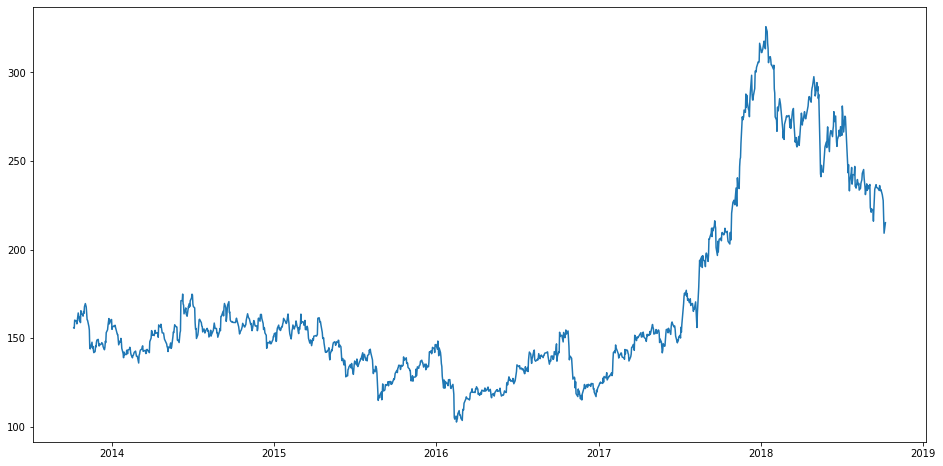

In [209]:
# 将索引设置为日期
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
df.index = df['Date']
df = df.sort_index(ascending=True, axis=0)

# 图表
plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Close Price history')

## 移动平均

In [210]:
# 使用日期和目标变量创建数据框
data = df[['Date', 'Close']].copy()

data.head()

,Date,Close
Date,,
2013-10-08,2013-10-08,155.80
2013-10-09,2013-10-09,155.55
2013-10-10,2013-10-10,160.15
2013-10-11,2013-10-11,160.05
2013-10-14,2013-10-14,159.45


In [211]:
# 拆分训练集和验证集
train = data[:987].copy()
valid = data[987:].copy()

In [212]:
data.shape, train.shape, valid.shape

((1235, 2), (987, 2), (248, 2))

In [213]:
train['Date'].min(), train['Date'].max(), valid['Date'].min(), valid['Date'].max()

(Timestamp('2013-10-08 00:00:00'),
 Timestamp('2017-10-06 00:00:00'),
 Timestamp('2017-10-09 00:00:00'),
 Timestamp('2018-10-08 00:00:00'))

In [214]:
# 做出预测
preds = []
for i in range(0,248):
    a = train['Close'][-248+i:].sum() + sum(preds)
    b = a/248
    preds.append(b)

In [217]:
# 计算rmse
rms = np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
rms

104.51415465984356

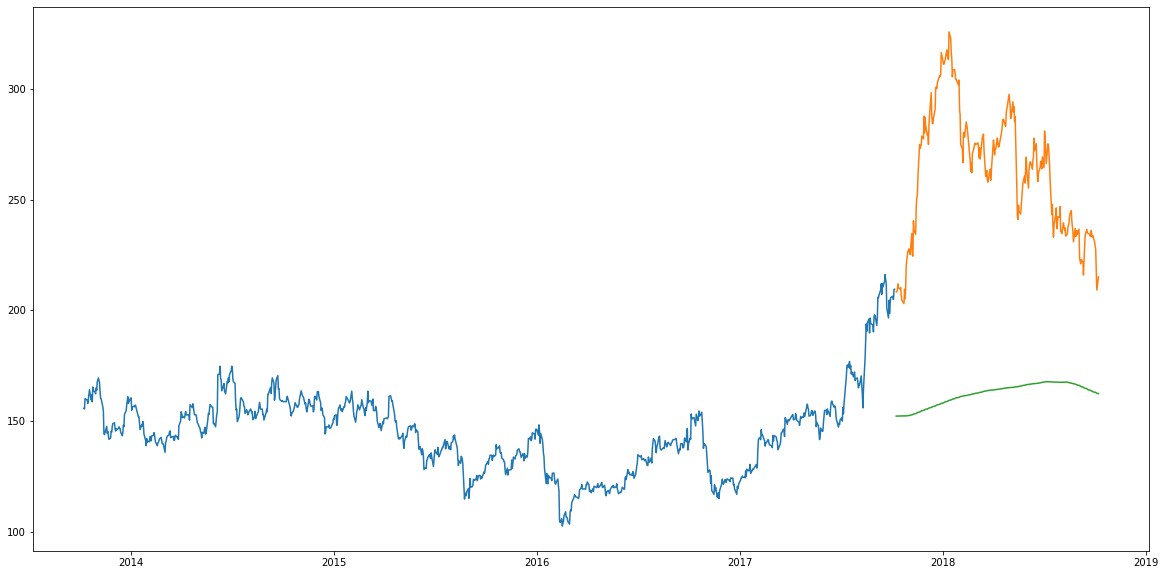

In [218]:
# 图表
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

## 线性回归

In [219]:
# 创建特征
# from fastai.structured import add_datepart
from fastai.tabular.transform import add_datepart

In [221]:
data = df[['Date', 'Close']].copy()

add_datepart(data, 'Date')
data.drop('Elapsed', axis=1, inplace=True)

In [222]:
data.head()

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start
Date,,,,,,,,,,,,,
2013-10-08,155.80,2013,10,41,8,1,281,False,False,False,False,False,False
2013-10-09,155.55,2013,10,41,9,2,282,False,False,False,False,False,False
2013-10-10,160.15,2013,10,41,10,3,283,False,False,False,False,False,False
2013-10-11,160.05,2013,10,41,11,4,284,False,False,False,False,False,False
2013-10-14,159.45,2013,10,42,14,0,287,False,False,False,False,False,False


In [223]:
data['mon_fri'] = np.where(data['Dayofweek'] == 0, 1, np.where(data['Dayofweek'] == 4 ,1, 0))

In [224]:
# 拆分训练集和验证集
train = data[:987].copy()
valid = data[987:].copy()

X_train = train.drop('Close', axis=1)
y_train = train['Close']
X_valid = valid.drop('Close', axis=1)
y_valid = valid['Close']

In [225]:
# 实现线性回归
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [226]:
# 做出预测并找到rmse
preds = model.predict(X_valid)
rms = np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

121.16291596522859

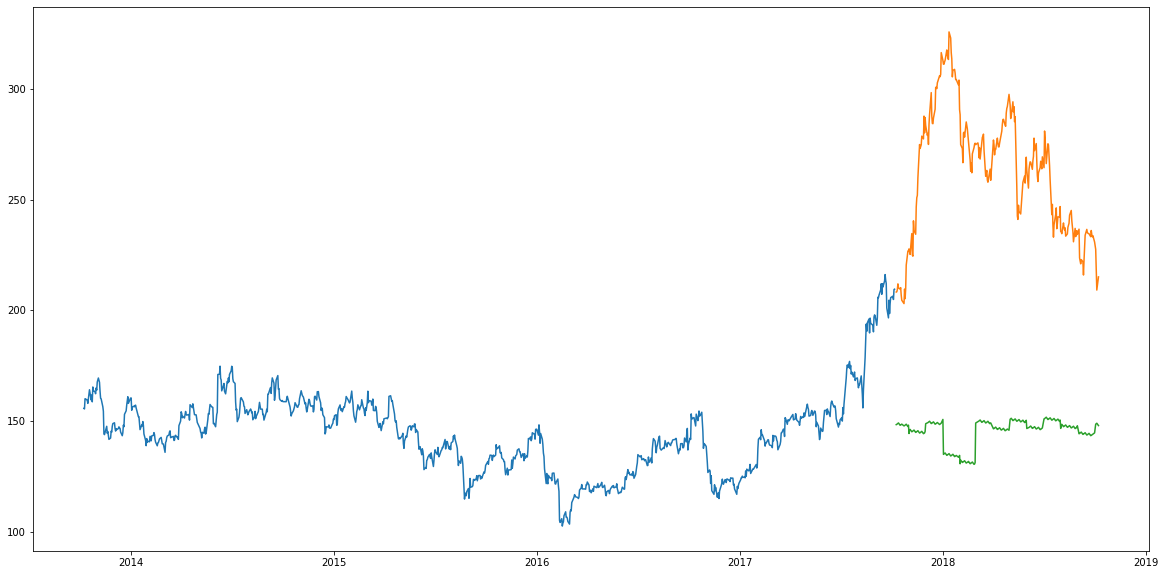

In [227]:
# 图表
valid['Predictions'] = preds

plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])

## k-近邻

In [228]:
# 导入库
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [229]:
# 缩放数据
scaler = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled)
X_valid_scaled = scaler.fit_transform(X_valid)
X_valid = pd.DataFrame(X_valid_scaled)

# 使用gridsearch查找最佳参数
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

# 拟合模型并进行预测
model.fit(X_train, y_train)
preds = model.predict(X_valid)

D:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype bool, int32, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
D:\Program Files\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype bool, int32, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
D:\Program Files\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [230]:
# rmse
rms = np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

115.17086550026723

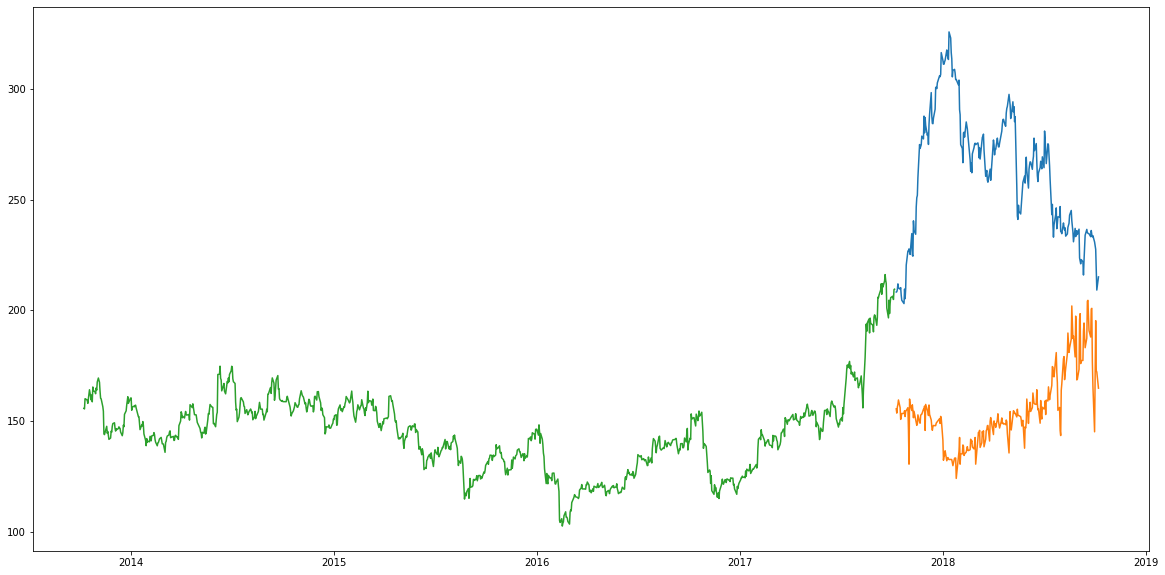

In [231]:
# 图表
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(valid[['Close', 'Predictions']])
plt.plot(train['Close'])

## 自动ARIMA

In [232]:
# pip install pyramid-arima
# pip install --user pmdarima

In [233]:
# from pyramid.arima import auto_arima
from pmdarima.arima import auto_arima

data = df[['Date', 'Close']].copy()

train = data[:987].copy()
valid = data[987:].copy()

training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,
                   d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

pred = model.predict(n_periods=248)
forecast = pd.DataFrame(pred, index=valid.index, columns=['Prediction'])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4820.561, BIC=4844.968, Fit time=5.454 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5479.245, BIC=5489.008, Fit time=0.065 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=5170.275, BIC=5189.801, Fit time=1.285 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4818.529, BIC=4838.055, Fit time=4.159 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=5477.259, BIC=5482.140, Fit time=0.046 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=5483.137, BIC=5502.663, Fit time=0.772 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4817.546, BIC=4846.835, Fit time=9.899 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 12); setting score to inf (at 

In [234]:
rms = np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

44.93201550495584

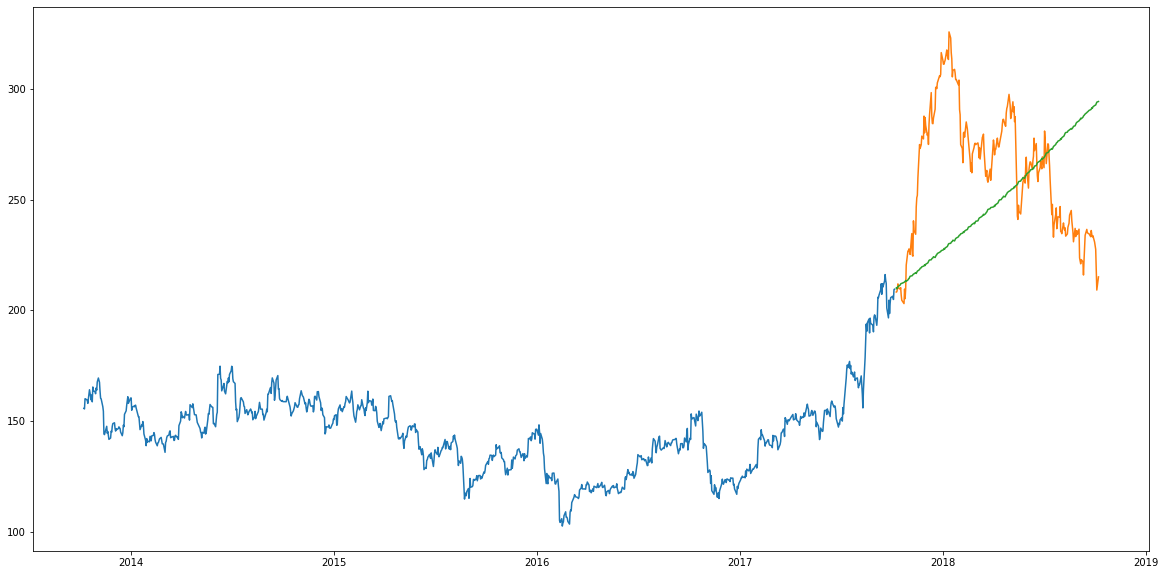

In [235]:
# 图表
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

## Prophet

In [118]:
# pip install pystan
# python setup.py install

In [236]:
# 导入prophet
from fbprophet import Prophet

# 创建数据框
data = df.sort_index(ascending=True, axis=0)[['Date', 'Close']].copy()

# 准备数据
data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

# 训练集和预测集
train = data[:987].copy()
valid = data[987:].copy()

# 拟合模型
model = Prophet()
model.fit(train)

# 预测
close_prices  = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [237]:
# rmse
forecast_valid = forecast['yhat'][987:]
rms = np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rms

57.480395942407526

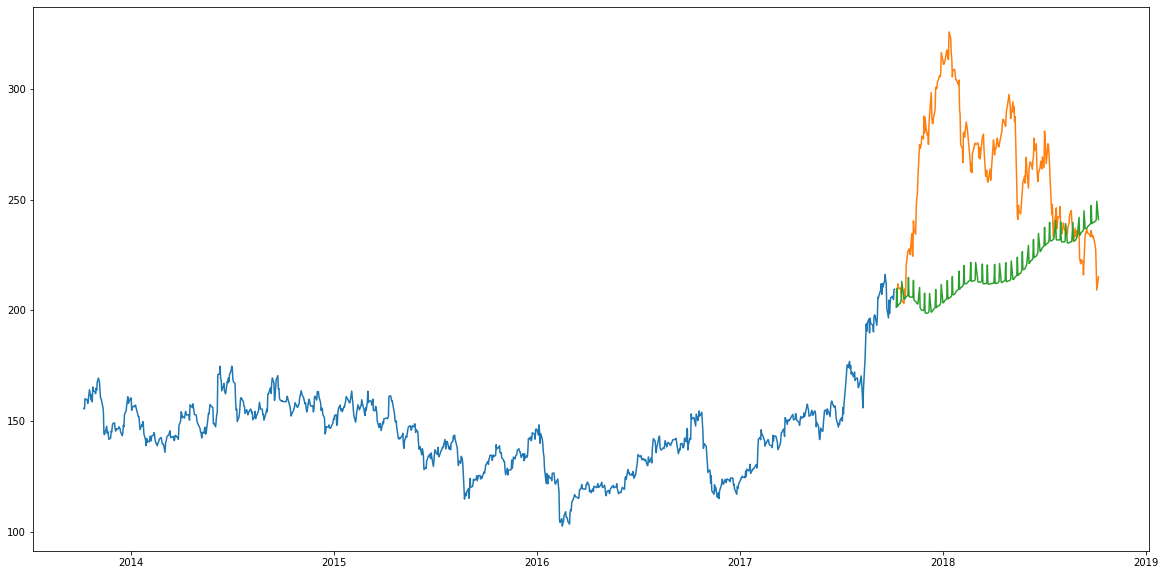

In [238]:
# 图表
valid['Predictions'] = forecast_valid.values

plt.plot(train['y'])
plt.plot(valid[['y', 'Predictions']])

## 长短期记忆(LSTM)

In [251]:
# 导入所需的库
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [252]:
# 创建数据框
data = df.sort_index(ascending=True, axis=0)[['Date', 'Close']].copy()

# 创建训练集和验证集
train = data[:987].copy()
valid = data[987:].copy()

In [253]:
# 将数据集转换为x_train和y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']].values)

In [254]:
X_train, y_train = [], []

# 按每60天作为特征输入
for i in range(60,len(train)):
    X_train.append(scaled_data[i-60:i, 0])
    y_train.append(scaled_data[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [255]:
X_train.shape, y_train.shape

((927, 60), (927,))

In [256]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))

In [257]:
X_train.shape

(927, 60, 1)

In [258]:
# 创建和拟合LSTM网络
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 199s - loss: 0.0012


In [259]:
# 使用过去值来预测246个值
inputs = data[len(data) - len(valid) - 60:]['Close'].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
inputs.shape

(308, 1)

In [260]:

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1], 1))
closing_price = model.predict(X_test)
# closing_price = scaler.inverse_transform(closing_price)
closing_price = closing_price.reshape((len(valid),))

In [261]:
rms = np.sqrt(np.mean(np.power((valid['Close']-closing_price),2)))
rms

263.4547317502094

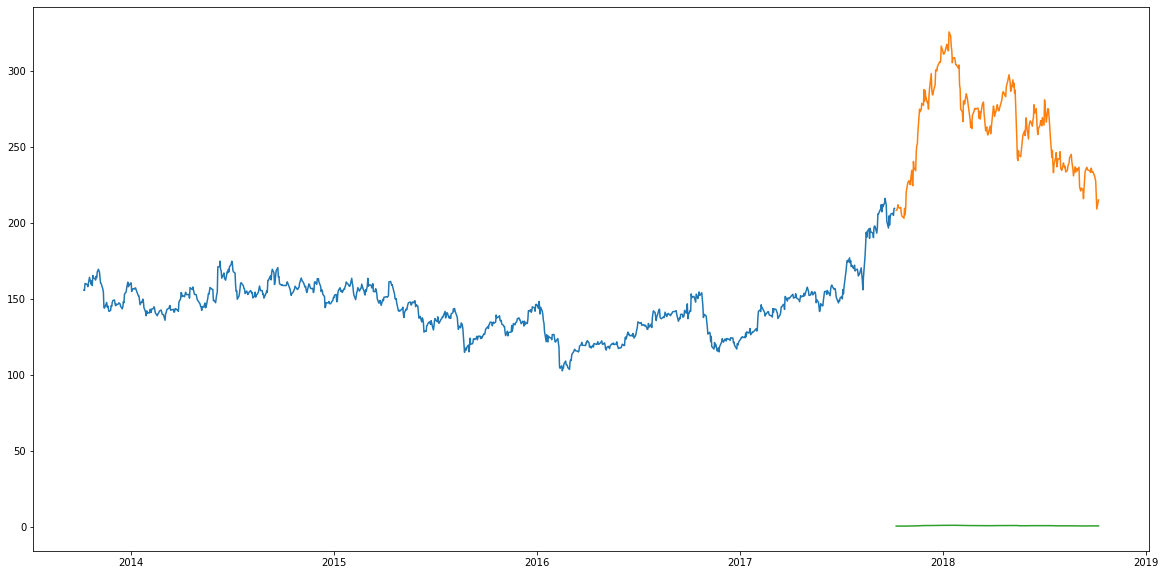

In [262]:
# 用于绘图
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])